In [4]:
import SimpleITK as sitk
from subprocess import Popen
import subprocess
import SimpleITK as sitk
import pandas as pd
import multiprocessing as mp
import functools
from functools import partial
import sys
import os.path
from os import path as pathOs
import numpy as np
import tempfile
import shutil
from os.path import basename, dirname, exists, isdir, join, split
from pathlib import Path
import fileinput
import re
import subprocess
from toolz.itertoolz import groupby
import seaborn as sns
import einops
import matplotlib.pyplot as plt
import itertools
import SimpleITK as sitk
import mdai
import pandas as pd
import numpy as np
import cv2
import pydicom
import os
import multiprocessing as mp
import functools
from functools import partial
import mdai
import math
import time
import itertools
from pydicom.fileset import FileSet
from os import path as pathOs
from pathlib import Path
import toolz
from toolz.curried import pipe, map, filter, get
from toolz import curry
from os.path import basename, dirname, exists, isdir, join, split
import nnunetv2

import elastixRegister as elastixRegister
from elastixRegister import reg_a_to_b
import tempfile
import shutil
import re
from toolz.itertoolz import groupby
from toolz import curry
# import multiprocess
# p = multiprocess.Pool(os.cpu_count())
import multiprocessing as mp
import json
import os
from subprocess import Popen
import subprocess
from skimage.segmentation import mark_boundaries
from scipy import ndimage

import SimpleITK as sitk
import mdai
import pandas as pd
import numpy as np
import cv2
import pydicom
import os
import multiprocessing as mp
import functools
from functools import partial
import mdai
import math
import time
import itertools
from pydicom.fileset import FileSet
from os import path as pathOs
from pathlib import Path
import toolz
from toolz.curried import pipe, map, filter, get
from toolz import curry
from os.path import basename, dirname, exists, isdir, join, split
import nnunetv2

# from elastixRegister import reg_a_to_b,reg_a_to_b_be_meta_data,reg_a_to_b_by_metadata_single_b
import tempfile
import shutil
import re
from toolz.itertoolz import groupby
from toolz import curry
# import multiprocess
# p = multiprocess.Pool(os.cpu_count())
import multiprocessing as mp
import json
import os
from subprocess import Popen
import subprocess
import os
import subprocess
from pathlib import Path

import SimpleITK as sitk
from evalutils import SegmentationAlgorithm
from evalutils.validators import (UniqueImagesValidator,
                                  UniquePathIndicesValidator)
from picai_prep.data_utils import atomic_image_write
from picai_prep.preprocessing import (PreprocessingSettings, Sample,
                                      resample_to_reference_scan)


elacticPath='/home/sliceruser/elastixBase/elastix-5.0.1-linux/bin/elastix'
transformix_path='/home/sliceruser/elastixBase/elastix-5.0.1-linux/bin/transformix'
reg_prop='/workspaces/konwersjaJsonData/nnunet/registration/parameters.txt'  
# dataframe with master ids that we should not include in training
test_ids_CSVDir='/workspaces/konwersjaJsonData/test_ids.csv'
test_ids=pd.read_csv(test_ids_CSVDir)['ids'].to_numpy().flatten()



def reg_a_to_b_by_metadata_single_b(fixed_image_path,moving_image_path,out_folder, interpolator=sitk.sitkNearestNeighbor):
    if(len(moving_image_path)<4):
        moving_image_path=moving_image_path[0]
    fixed_image=sitk.ReadImage(fixed_image_path)
    moving_image=sitk.ReadImage(moving_image_path)

    # fixed_image=sitk.Cast(fixed_image, sitk.sitkUInt8)
    # moving_image=sitk.Cast(moving_image, sitk.sitkInt)
    
    arr=sitk.GetArrayFromImage(moving_image)
    resampled=sitk.Resample(moving_image, fixed_image, sitk.Transform(3, sitk.sitkIdentity), interpolator, 0)
    
    # print(f" prim sum {np.sum(sitk.GetArrayFromImage(sitk.ReadImage(moving_image_path)).flatten())} \n suuum {np.sum(sitk.GetArrayFromImage(resampled).flatten())} ")
  
    writer = sitk.ImageFileWriter()
    new_path= join(out_folder,moving_image_path.split('/')[-1])
    writer.SetFileName(new_path)
    writer.Execute(resampled)

    return new_path

def reg_a_to_b_by_metadata_single_f(fixed_image_path,moving_image_path,interpolator):

    fixed_image=sitk.ReadImage(fixed_image_path)
    moving_image=sitk.ReadImage(moving_image_path)
    arr=sitk.GetArrayFromImage(moving_image)
    resampled=sitk.Resample(moving_image, fixed_image, sitk.Transform(3, sitk.sitkIdentity), interpolator, 0)
    return resampled



def reg_a_to_b_by_metadata_single_g(fixed_image_path,moving_image_path,out_folder, interpolator=sitk.sitkNearestNeighbor):
    if(len(moving_image_path)<4):
        moving_image_path=moving_image_path[0]
    fixed_image=sitk.ReadImage(fixed_image_path)
    moving_image=sitk.ReadImage(moving_image_path)

    # fixed_image=sitk.Cast(fixed_image, sitk.sitkUInt8)
    # moving_image=sitk.Cast(moving_image, sitk.sitkInt)
    
    arr=sitk.GetArrayFromImage(moving_image)
    resampled=sitk.Resample(moving_image, fixed_image, sitk.Transform(3, sitk.sitkIdentity), interpolator, 0)
    
    # print(f" prim sum {np.sum(sitk.GetArrayFromImage(sitk.ReadImage(moving_image_path)).flatten())} \n suuum {np.sum(sitk.GetArrayFromImage(resampled).flatten())} ")
  
    writer = sitk.ImageFileWriter()
    new_path= moving_image_path
    writer.SetFileName(new_path)
    writer.Execute(resampled)

    return new_path


def groupByMaster(rowws):
    grouped_by_master= groupby(lambda row : row[1]['masterolds'],rowws)
    # grouped_by_master=[(key,list(group)) for key, group in grouped_by_master]
    return dict(grouped_by_master).items()



def get_bool_arr_from_path(pathh):
    """
    given path reads it and return associated array
    then it casts it to boolean data type
    """
    imageA=sitk.ReadImage(pathh)
    return sitk.GetArrayFromImage(imageA).astype(bool)


def getPathsFromRow(row,list_columns):
    """
    extracting all paths of intrest from row
    """
    res=  map( lambda colName : (colName,row[1][colName] ),list_columns )
    return res

def getListModality(modalityName,pathhs,non_mri_inputs):
    """
    getting paths related to single modality and extracting main MRI image
    non_mri_inputs - some inputs that are designed to be put into input channels 
    """
    if(modalityName not in non_mri_inputs):
        # we are intrested only in paths that has the prostate segmentation
        pathhs=list(map(lambda el: el[1],pathhs))
        # pathhs= list(filter(lambda el :"pg_t2w.nii.gz" not in el , pathhs))
        mod_paths = list(filter(lambda pathh :modalityName in  pathh,pathhs))
        mri = list(filter(lambda el: '.mha' in el ,mod_paths))
        if(len(mri)==0):
            return ' ',[]
        mri=mri[0]   
        mod_paths= list(filter(lambda pathh: '.mha' not in pathh , mod_paths))
        return (modalityName,(mri,np.unique(mod_paths).tolist()))
    
    elif(modalityName in non_mri_inputs):
        # colNames=list(map(lambda el: el[0],pathhs))
        pathhss= list(filter(lambda el :modalityName in el[0] , pathhs))   
        if(len(pathhss)==0):
            return ' ',[]        
        res= (modalityName, (modalityName,np.unique(pathhss[0][1]).tolist())  )
        return res


def myFlatten(liist):
    return  itertools.chain(*liist)

def map_modalities(pathhs,modalities,non_mri_inputs):
    all_modalities=modalities+non_mri_inputs
    res= toolz.pipe(all_modalities
                ,map(partial(getListModality,pathhs=pathhs,non_mri_inputs=non_mri_inputs))
                ,list
            )
    # print(f"gggg {res}")
    return res



def iterGroupModalities(groupTuple,modalities_of_intrest,label_cols,non_mri_inputs ):
    """
    grouping the paths into dictionary relative to modalities they represent and lesions on thise 
    modalities
    """
    masterOlds, listRows= groupTuple
    pathhs=toolz.pipe(listRows
                ,map(partial(getPathsFromRow,list_columns=np.unique(label_cols+['series_MRI_path']+non_mri_inputs)))
                ,myFlatten
                # ,filter(lambda el : len(el)>2)
                ,list
                ,partial(map_modalities,modalities=modalities_of_intrest,non_mri_inputs=non_mri_inputs)
                ,dict
                )   
    return (masterOlds,pathhs)



def get_bool_or(pathA,pathB):
    if(isinstance(pathA, str) and isinstance(pathB, str)):
        return np.logical_or(get_bool_arr_from_path(pathA),get_bool_arr_from_path(pathB))
    elif(isinstance(pathA, str) and not isinstance(pathB, str)):
        return np.logical_or(get_bool_arr_from_path(pathA),pathB)
    elif(not isinstance(pathA, str) and isinstance(pathB, str)):
        return np.logical_or(get_bool_arr_from_path(pathB),pathA)
    else:
        return np.logical_or(pathB,pathA)


def get_bool_and(pathA,pathB):
    if(isinstance(pathA, str) and isinstance(pathB, str)):
        return np.logical_and(get_bool_arr_from_path(pathA),get_bool_arr_from_path(pathB))
    elif(isinstance(pathA, str) and not isinstance(pathB, str)):
        return np.logical_and(get_bool_arr_from_path(pathA),pathB)
    elif(not isinstance(pathA, str) and isinstance(pathB, str)):
        return np.logical_and(get_bool_arr_from_path(pathB),pathA)
    else:
        return np.logical_and(pathB,pathA)

def get_4_id(masterolds):
    """
    take master id and changes it into string that starts with 0s and have always length 4
    """
    masteroldsStand=str(masterolds)
    if(len(masteroldsStand)==1):
        return f"000{masteroldsStand}"
    elif(len(masteroldsStand)==2):
        return f"00{masteroldsStand}"
    elif(len(masteroldsStand)==3):
        return f"0{masteroldsStand}"
    return masteroldsStand


def get_id_from_file_name(path_str):
    path_str=path_str.replace('.nii.gz','')
    path_str=path_str[1:5]
    return int(path_str)

def add_t2w_to_name(source):
    if(source==' '):
        return ' '
    if('t2w' in source):
        return source
    new_path= source.replace('.nii.gz','_t2w.nii.gz')
    copy_changing_type(source, new_path)
    return new_path

def add_inferred_full_prost_to_dataframe(dir_inferred_prost, df,new_col_name):
    """ 
    we have some inferred anatomical segmentations done by previous 
    models now we want to take the folder with 
    """
    list_files= os.listdir(dir_inferred_prost)
    list_files= list(filter(lambda el : el[0]=='9' ,list_files ))
    list_ids= list(map(get_id_from_file_name,list_files))
    list_files= list(map( lambda el: f"{dir_inferred_prost}/{el}" ,list_files))
    file_and_id= dict(list(zip(list_ids,list_files)))
    new_col_dat= list(map( lambda el: file_and_id.get(el,' ') ,df['masterolds'].to_numpy() ))
    #changing path name to mark it is t2w related
    new_col_dat= list(map(add_t2w_to_name,new_col_dat))

    df[new_col_name]=new_col_dat
    return df


def get_from_arr(zeroArray,image3D):
    """
    given array saves it to file into defined path using simpleitk
    """
    image = sitk.GetImageFromArray(zeroArray.astype(float).astype(np.uint8))  
    # nan_count=np.sum(np.isnan(np.array(sitk.GetArrayFromImage(image)).flatten()))
    # if(nan_count>0):
    #     raise ValueError(f"!!! nan in image would be saved as {newPathLab}")

    image.SetSpacing(image3D.GetSpacing())
    image.SetOrigin(image3D.GetOrigin())
    image.SetDirection(image3D.GetDirection())   
    image = sitk.DICOMOrient(image, 'LPS')
    return image


def save_from_arr(zeroArray,image3D,newPathLab):
    """
    given array saves it to file into defined path using simpleitk
    """
    writer = sitk.ImageFileWriter()
    image = get_from_arr(zeroArray,image3D)
    # image.SetDirection((1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)) 
    writer.SetFileName(newPathLab)
    writer.Execute(image)
    return newPathLab

def copy_changing_type(source, dest):
    image= sitk.ReadImage(source)
    # nan_count=np.sum(np.isnan(np.array(sitk.GetArrayFromImage(image)).flatten()))
    # if(nan_count>0):
    #     raise ValueError(f"!!! nan in {source}")
    image = sitk.DICOMOrient(image, 'LPS')
    image.SetDirection((1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)) 
    image=sitk.Cast(image, sitk.sitkFloat32)
    writer = sitk.ImageFileWriter() 
    writer.SetFileName(dest)
    writer.Execute(image)
    return dest

# mod="adc"
def get_key_by_value(mod,channel_names):
    return list(channel_names.keys())[list(channel_names.values()).index(mod)]

def prepare_out_paths(group,modalities_of_intrest,labelsTrFolder,imagesTrFolder,non_mri_inputs,channel_names ):
    #preparing names
    for_id=get_4_id(group[0])
    label_new_path= join(labelsTrFolder,f"9{for_id}00.nii.gz" )
    # prostate_path=join(imagesTrFolder,f"9{for_id}00_000{3}.nii.gz" )
    out_pathsDict= list(map( lambda mod:(mod,join(imagesTrFolder,f"9{for_id}00_000{get_key_by_value(mod,channel_names)}.nii.gz" )) ,np.unique(modalities_of_intrest+non_mri_inputs) ))
    out_pathsDict=dict(out_pathsDict)
    return label_new_path,out_pathsDict






# def set_common_prhysical_data():

#     image_out.SetOrigin(img.GetOrigin())
#     image_out.SetSpacing(img.GetSpacing())
#     #set to RAI
#     image_out.SetDirection(tuple(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0))

def write_file(image,outputImageFileName):
    writer = sitk.ImageFileWriter()
    writer.SetFileName(outputImageFileName)
    writer.Execute(image)

def add_files(group,main_modality,modalities_of_intrest,reg_prop,elacticPath,transformix_path,labelsTrFolder
              ,imagesTrFolder,process_labels,non_mri_inputs,channel_names,is_to_preprocess ):
    """
    first register images and their respective labels to t2w
    then reduces all labels into their sum
    then saves mri and reduced labels into nnunet workdir to get structure the same as in baseline picai nnunet algorithm
    """
    modalit_path_add= list(map( lambda el:(group[1][el]) ,non_mri_inputs))
    filtered= list(filter(lambda el: el==' ',modalit_path_add))

    if len(filtered)!=0:
        return (' ',{})
    
    
    label_new_path,out_pathsDict=prepare_out_paths(group,modalities_of_intrest,labelsTrFolder,imagesTrFolder,non_mri_inputs,channel_names )
    label_new_path_prim=label_new_path
    temp_dir = tempfile.mkdtemp() # temporary directory
    modalities_of_intrest_without_main= list(filter( lambda el: el!=main_modality , modalities_of_intrest))
    modalities=[]
    labels=[]
    mris=[]
    newPaths=[]



    modalities.append(main_modality)
    # zipped_modalit_path = list(zip(modalities,mris))
    

    mris=list(map(lambda mod:   reg_a_to_b_by_metadata_single_b(group[1][main_modality][0],group[1][mod][0],temp_dir, sitk.sitkBSpline)
                 ,modalities_of_intrest_without_main))


    mris=list(mris)
    # mris.append(group[1][main_modality][0])    
    mris.append(group[1][main_modality][0])    
    modalities_of_intrest_without_main.append(main_modality)
    modalities=modalities_of_intrest_without_main

    #adding to the list the labels from main modality thay did not needed to be registered
    labels=np.array(labels+group[1][main_modality][1]).flatten()
    # print(f"labels {labels}  group[1][main_modality] {group[1][main_modality]} ")
    example_scan=[]
    
    if(len(labels)>0):
        zipped_modalit_path = list(zip(modalities,mris))
        # print(f"zipped_modalit_path {zipped_modalit_path}")
        #zipping for starmap use        
        zipped_modalit_path= list(map( lambda tupl:(tupl[1], out_pathsDict[tupl[0]]) ,zipped_modalit_path))
        # print(f"mmmm mris {mris} modalities_of_intrest {modalities_of_intrest}")
        mris_for_sample=[mris[2],mris[0],mris[1]]
        sample = Sample(
        scans=[
            sitk.ReadImage(str(path))
            for path in mris_for_sample
        ],
        settings=PreprocessingSettings(
            physical_size=[128.0, 96.0, 118.0],
            # physical_size=[138.0, 128.0, 124.0],
            crop_only=True
        )
        )

        # perform preprocessing
        sample.preprocess()
        # print(f"ssss sample.scans {sample.scans}")
        out=[zipped_modalit_path[2][1],zipped_modalit_path[0][1],zipped_modalit_path[1][1]]
        # list(itertools.starmap(write_file,list(zip(sample.scans, out ))))

        t2w_arr= sitk.GetArrayFromImage(sample.scans[0])
        adc_arr= sitk.GetArrayFromImage(sample.scans[1])
        hbv_arr= sitk.GetArrayFromImage(sample.scans[2])


        slicee=t2w_arr.shape[0]//2
        label_new_paths,newPaths= process_labels(labels,group,main_modality,label_new_path,newPaths,out_pathsDict)

        label_prim=sitk.GetArrayFromImage(sitk.ReadImage(label_new_paths[0]))

        label=sitk.Resample(sitk.ReadImage(label_new_paths[0]), sample.scans[0], sitk.Transform(3, sitk.sitkIdentity), sitk.sitkNearestNeighbor, 0)

        label=sitk.GetArrayFromImage(label)
        label=(label>0)
        # sns.heatmap(image_to_disp_big,cmap="Greys" ,ax=axs[0])
        # sns.heatmap(image_to_disp_on_x,cmap="Greys" ,ax=axs[1])
        # plt.imshow(with_boundaries)

        # sns.heatmap(adc_arr[slicee,:,:],cmap="Greys" ,ax=axs[2] )
        # sns.heatmap(hbv_arr[slicee,:,:],cmap="Greys" ,ax=axs[1] )
        # sns.heatmap(t2w_arr[slicee,:,:],cmap="Greys" ,ax=axs[0] )

        # plt.imshow(mark_boundaries(t2w_arr[t2w_arr.shape[0]//2,:,:],label.astype(int)) ,ax=axs[0])
        # plt.imshow(mark_boundaries(t2w_arr[:,t2w_arr.shape[1]//2,:],label.astype(int)),ax=axs[1] )
        # plt.imshow(mark_boundaries(t2w_arr[:,:,t2w_arr.shape[2]//2],label.astype(int)),ax=axs[2] )

        if(np.sum((label_prim>0).flatten())>np.sum(label.flatten())):
            fig, axs = plt.subplots(ncols=3,figsize=(30, 10))

            rows = 1
            columns = 3


            on_z=einops.reduce(label,'z x y-> z','sum')
            on_z=np.argmax(on_z)

            on_x=einops.reduce(label,'z x y-> x','sum')
            on_x=np.argmax(on_x)

            on_y=einops.reduce(label,'z x y-> y','sum')
            on_y=np.argmax(on_y)


            # Adds a subplot at the 1st position
            fig.add_subplot(rows, columns, 1)
            t2w_arr=t2w_arr*100
            # showing image
            plt.imshow(mark_boundaries(t2w_arr[on_z,:,:],label[on_z,:,:].astype(int)))
            plt.axis('off')

            # Adds a subplot at the 2nd position
            fig.add_subplot(rows, columns, 2)
            
            # showing image
            plt.imshow(mark_boundaries(t2w_arr[:,on_x,:],label[:,on_x,:].astype(int)))
            plt.axis('off')
            
            # Adds a subplot at the 3rd position
            fig.add_subplot(rows, columns, 3)
            
            # showing image
            plt.imshow(mark_boundaries(t2w_arr[:,:,on_y],label[:,:,on_y].astype(int)))
            plt.axis('off')
            




            # sns.heatmap(t2w_arr[t2w_arr.shape[0]//2,:,:],cmap="Greys" ,ax=axs[0])
            # sns.heatmap(t2w_arr[:,t2w_arr.shape[1]//2,:],cmap="Greys",ax=axs[1] )
            # sns.heatmap(t2w_arr[:,:,t2w_arr.shape[2]//2],cmap="Greys",ax=axs[2] )
            plt.show()
            # example_scan=zipped_modalit_path[2][1]



            return " " #(group[0],dict(newPaths))
    return " "



In [5]:

def main_prepare_nnunet(dataset_id, modalities_of_intrest,channel_names,label_names,label_cols,process_labels,non_mri_inputs
                        ,sourceFrame,main_modality,for_filter_unwanted=None,is_test_prep=False,is_to_preprocess=True,generate_plans=True):
    """
    main function for preparing nnunet
    """
    #first removing old data
    nNunetBaseFolder='/home/sliceruser/nnunetMainFolder'

    shutil.rmtree(f"{nNunetBaseFolder}/nnUNet_preprocessed")
    shutil.rmtree(f"{nNunetBaseFolder}/nnUNet_raw")


    taskName= f"Dataset{dataset_id}_Prostate"
    taskFolder = join(nNunetBaseFolder,'nnUNet_raw',taskName)
    preprocesss_folder= join(nNunetBaseFolder,'nnUNet_preprocessed')
    results_folder= join(nNunetBaseFolder,'nnUNet_results')
    mainResults_folder="/home/sliceruser/nnUNet_results"
    imagesTrFolder= join(taskFolder,'imagesTr')
    labelsTrFolder= join(taskFolder,'labelsTr')
    imagesTsFolder= join(taskFolder,'imagesTs')
    json_path= join(taskFolder,'dataset.json')

    # main modality that will be set as a reference and others will be registered to it 


    os.makedirs(nNunetBaseFolder ,exist_ok = True)
    # os.makedirs(join(nNunetBaseFolder,'nnUNet_raw_data_base') ,exist_ok = True)
    # os.makedirs(join(nNunetBaseFolder,'nnUNet_raw_data_base','nnUNet_raw_data') ,exist_ok = True)
    os.makedirs(taskFolder ,exist_ok = True)
    os.makedirs(imagesTrFolder ,exist_ok = True)
    os.makedirs(labelsTrFolder ,exist_ok = True)
    os.makedirs(preprocesss_folder ,exist_ok = True)
    os.makedirs(results_folder ,exist_ok = True)
    os.makedirs(mainResults_folder ,exist_ok = True)
    os.makedirs(join(mainResults_folder,taskName),exist_ok = True)
    

    if(for_filter_unwanted==None):
        for_filter_unwanted=lambda group: True
    grouped_rows=[]
    
    filter_out_test_ids=lambda row: row[1]['masterolds'] not in test_ids
    filter_in_test_ids=lambda row: row[1]['masterolds'] in test_ids
    filter_ids=filter_out_test_ids


    label_paths= toolz.pipe(sourceFrame.iterrows()
                            ,filter(lambda row: row[1]['series_desc'] in modalities_of_intrest)
                            ,filter(filter_ids) # filter out all of the test cases
                            ,groupByMaster
                            ,map(partial(iterGroupModalities,modalities_of_intrest=modalities_of_intrest,label_cols=label_cols,non_mri_inputs=non_mri_inputs))
                            ,list
                            ,filter(lambda group: ' ' not in group[1].keys() )
                            ,filter(for_filter_unwanted )
                            ,list
                            ,map(partial(add_files,main_modality=main_modality,modalities_of_intrest=modalities_of_intrest,reg_prop=reg_prop,
                                            elacticPath=elacticPath,transformix_path=transformix_path,labelsTrFolder=labelsTrFolder,imagesTrFolder=imagesTrFolder
                                            ,process_labels=process_labels,non_mri_inputs=non_mri_inputs,channel_names=channel_names,is_to_preprocess=is_to_preprocess ))
                            ,list
                            ,filter(lambda el: el!=' ')                                
                            ,list
                            )




    return grouped_rows

[0 1 2 3]
[0 1 2 3]


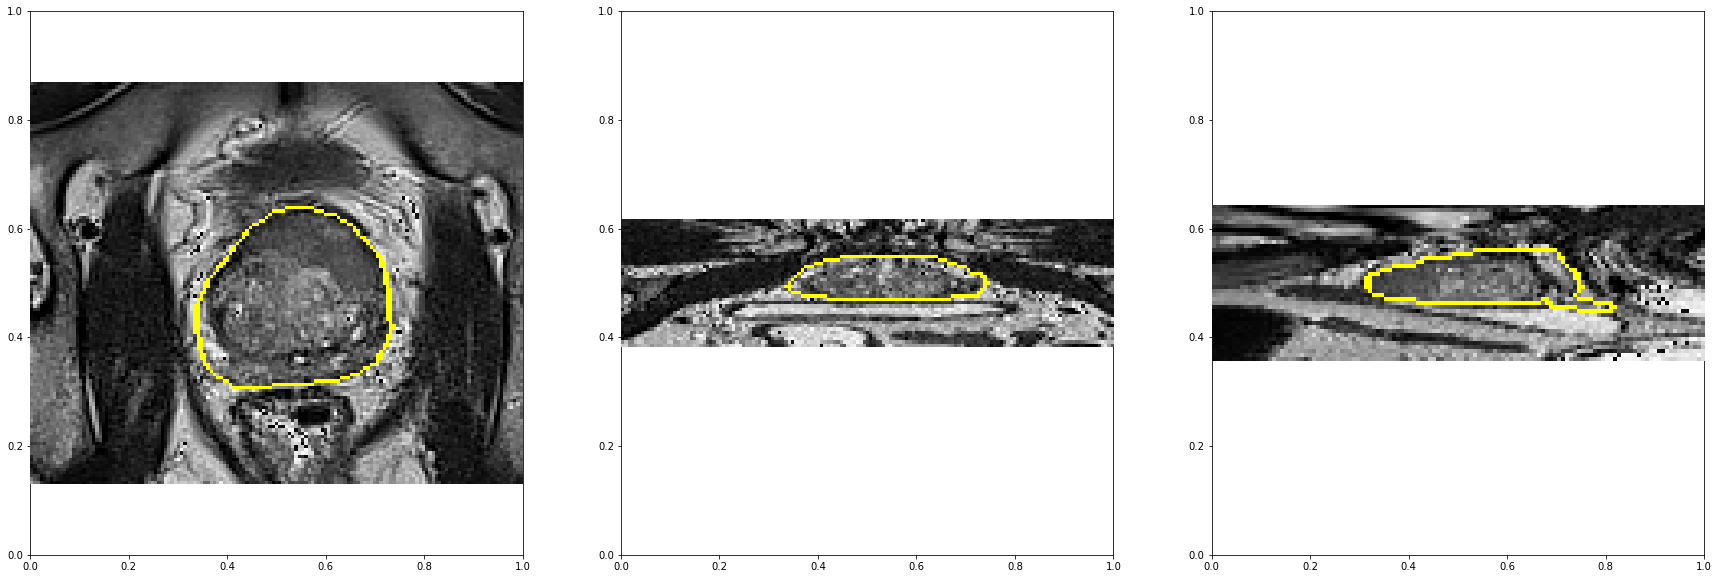

[0 1 2 3]


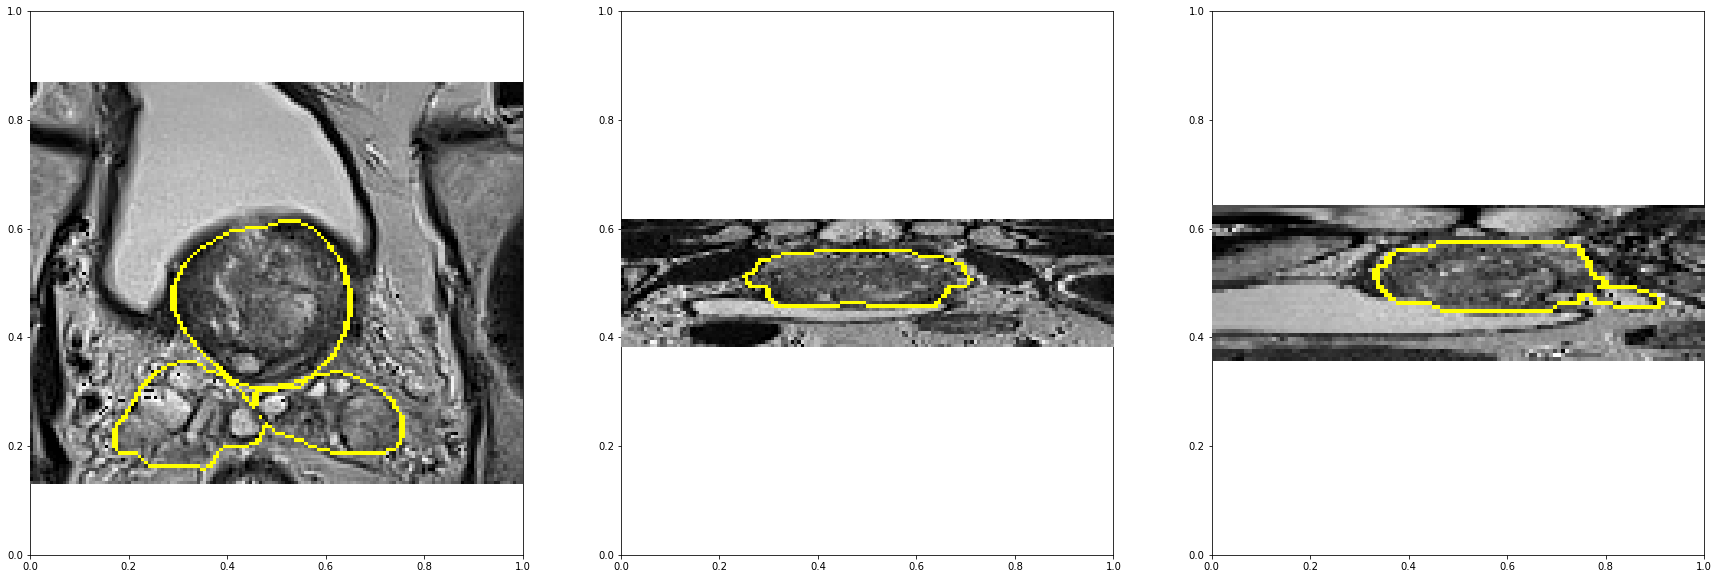

[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]


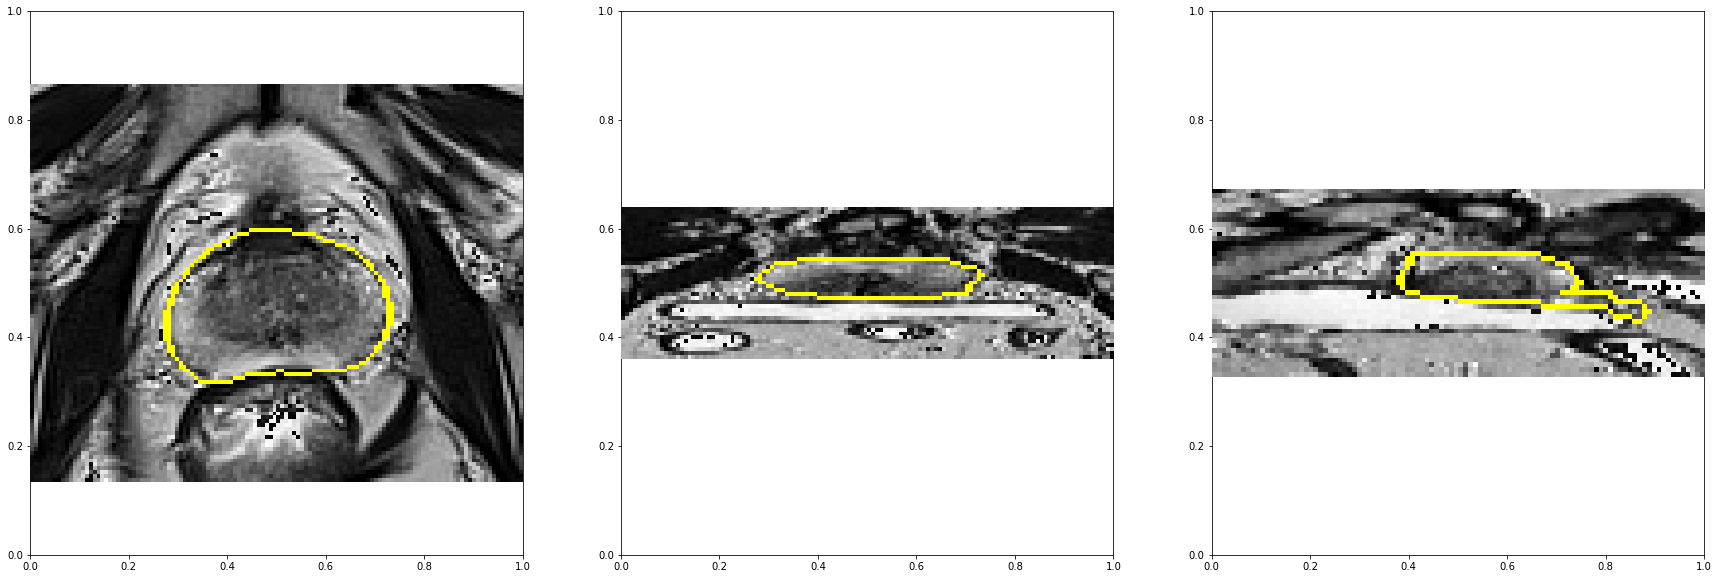

[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]


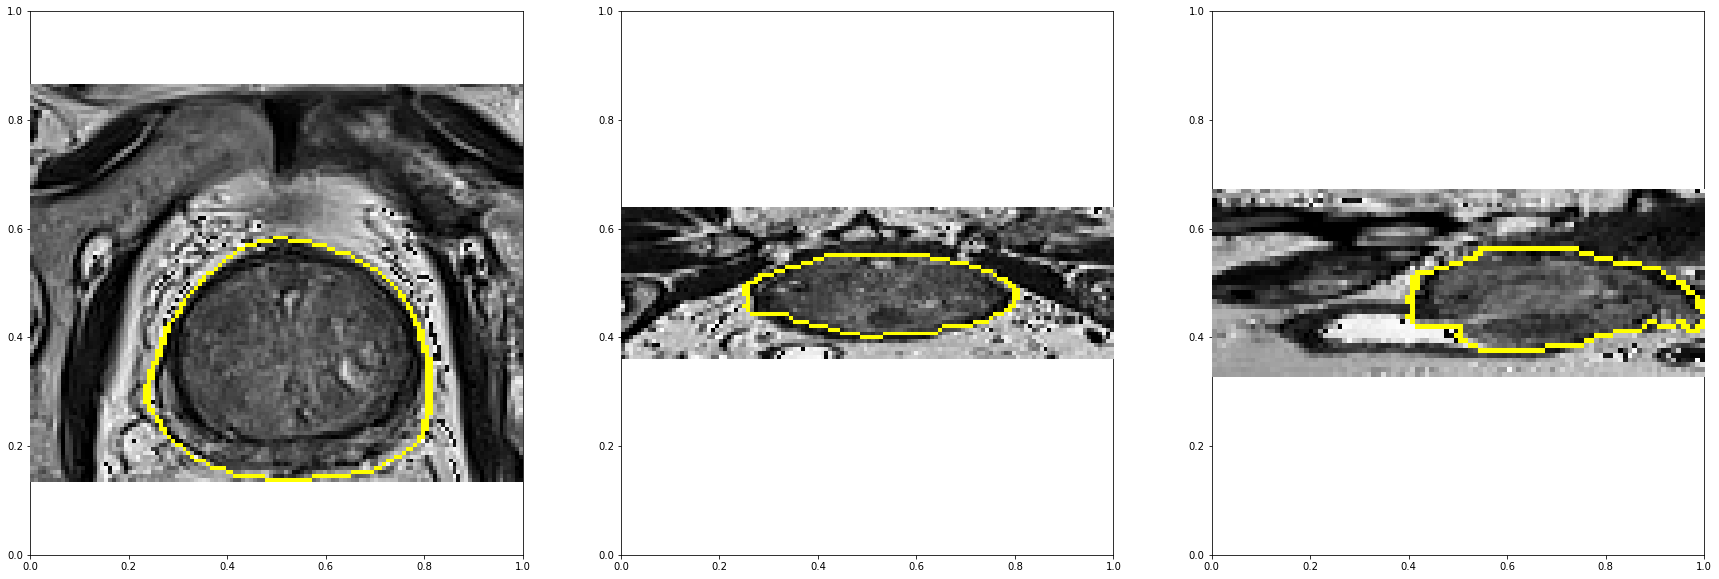

[0 1 2 3]


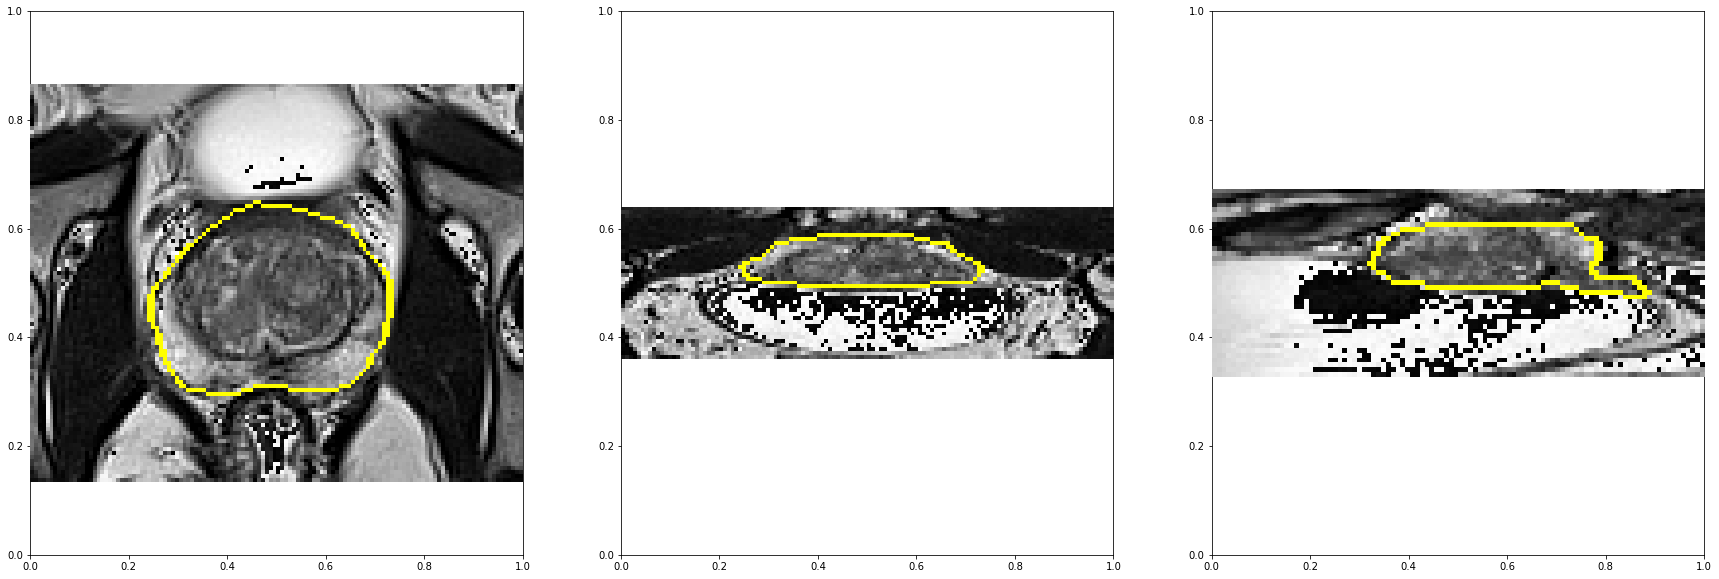

[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]


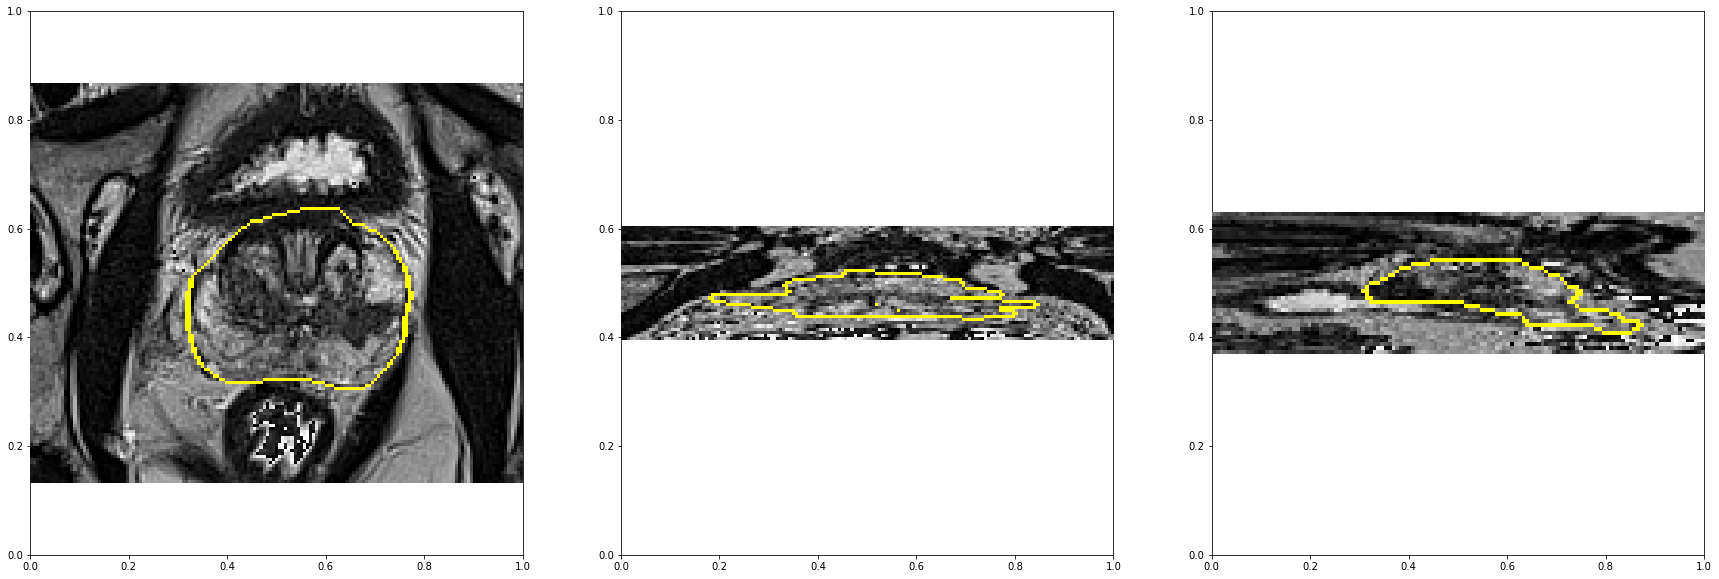

[0 1 2 3]


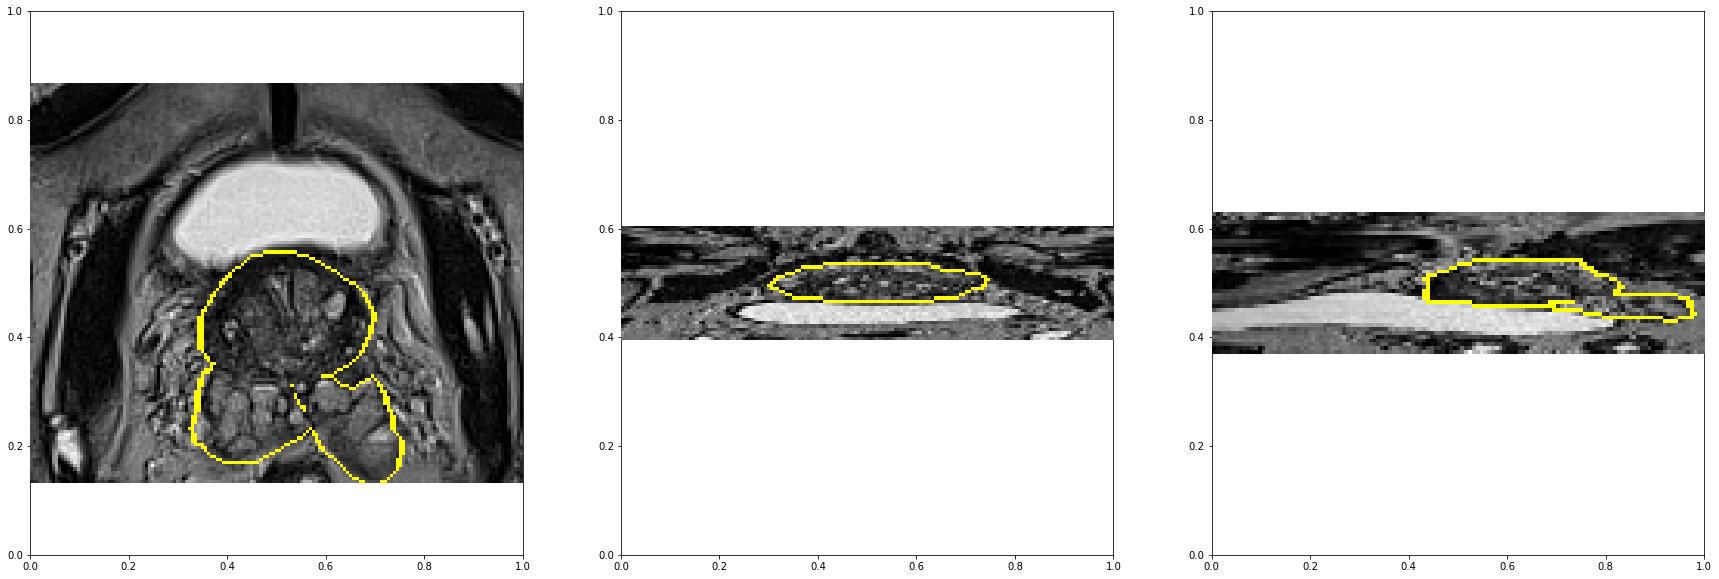

[0 1 2 3]


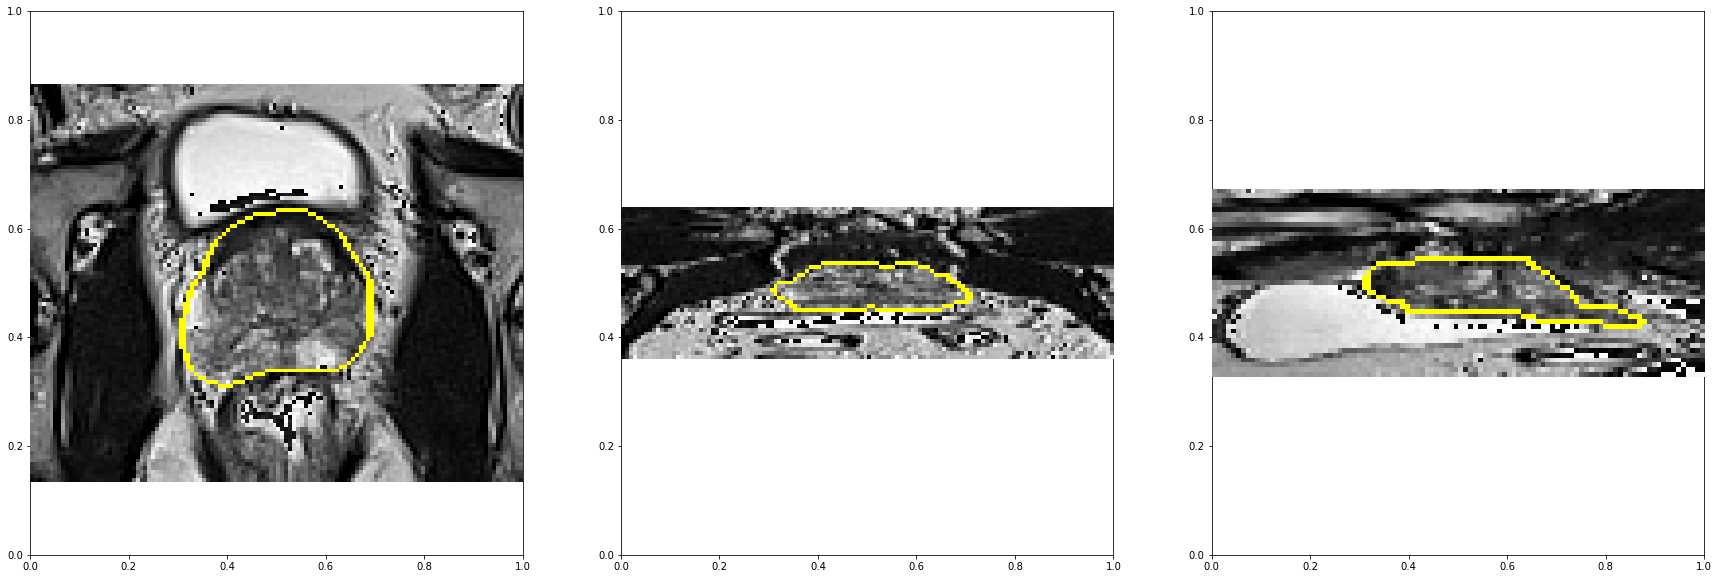

[0 1 2 3]
[0 1 2 3]


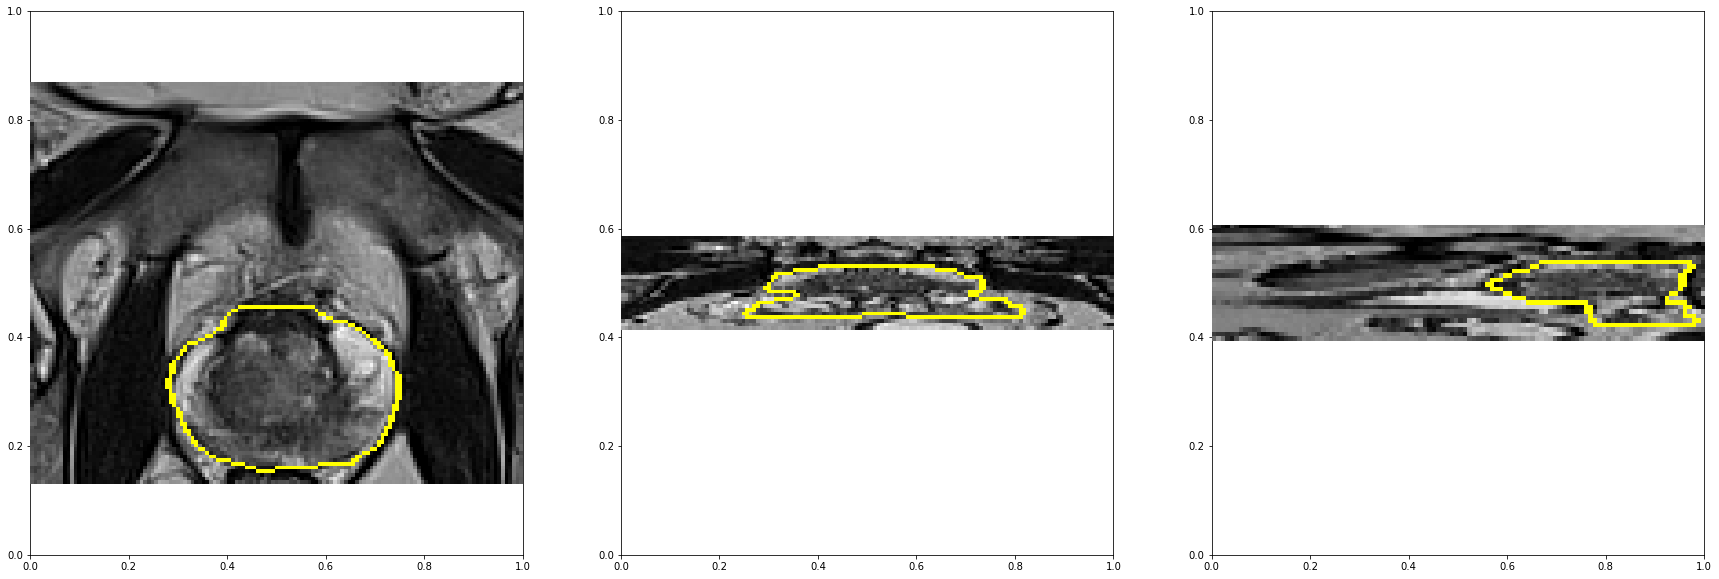

[0 1 2 3]


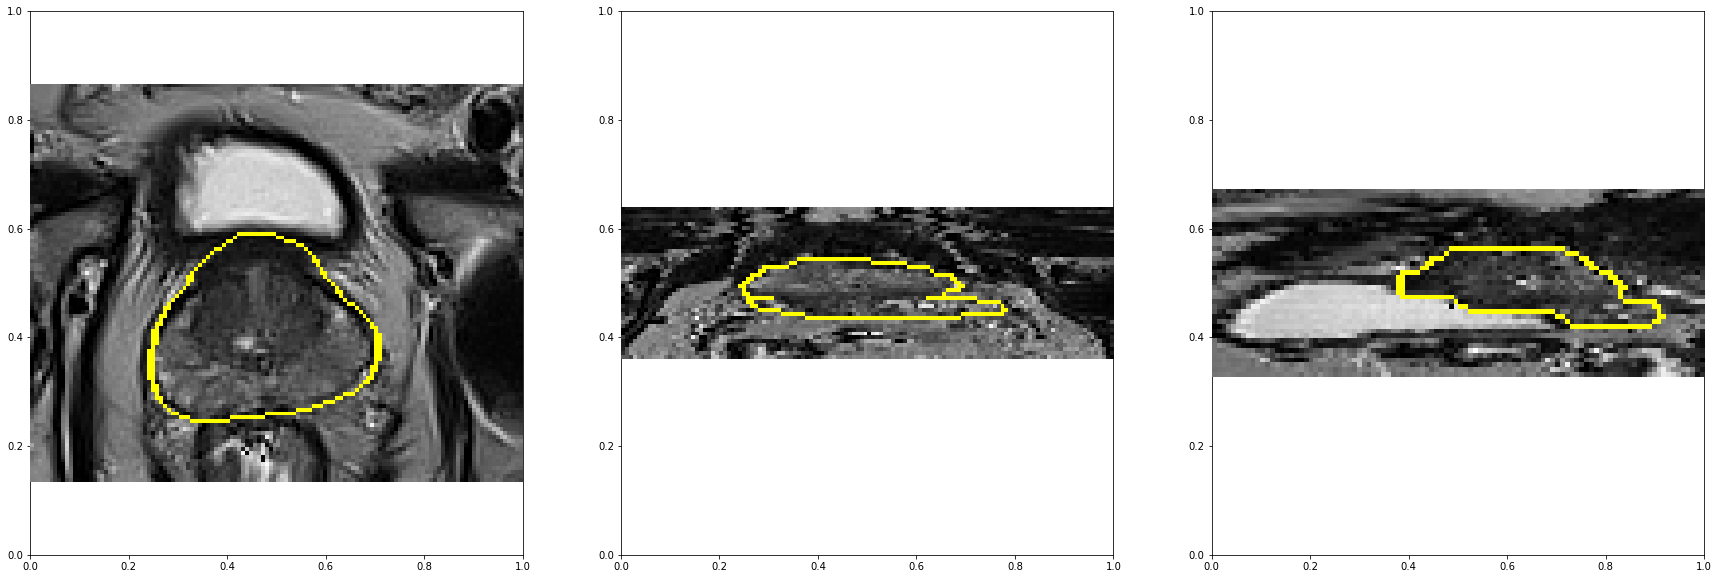

[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]


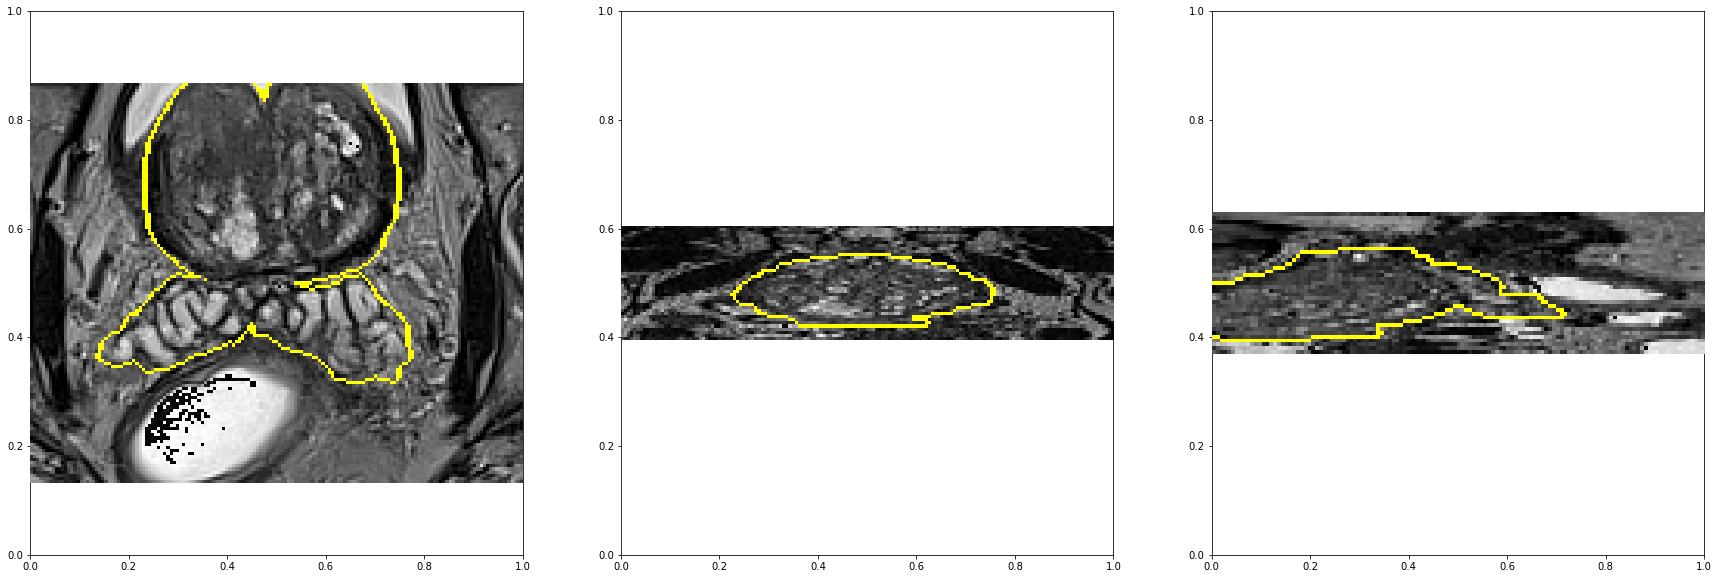

[0 1 2 3]
[0 1 2 3]


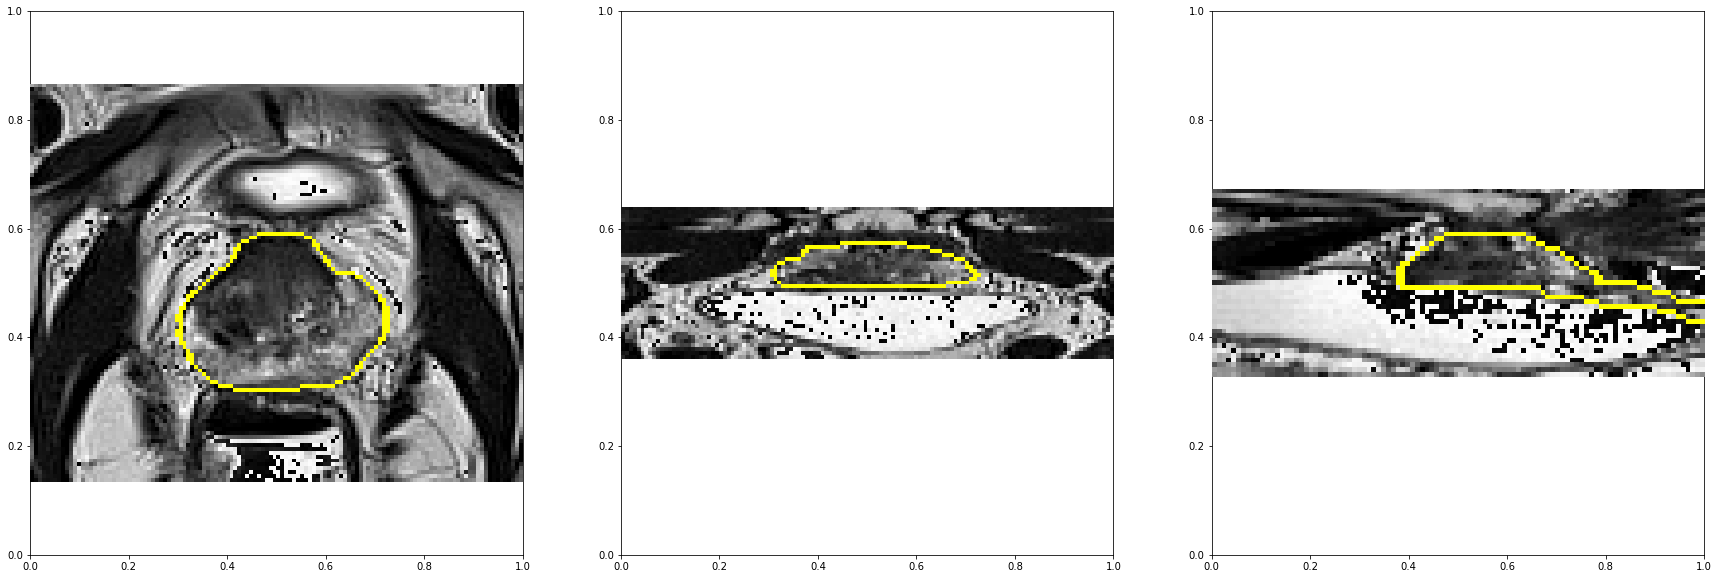

[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]


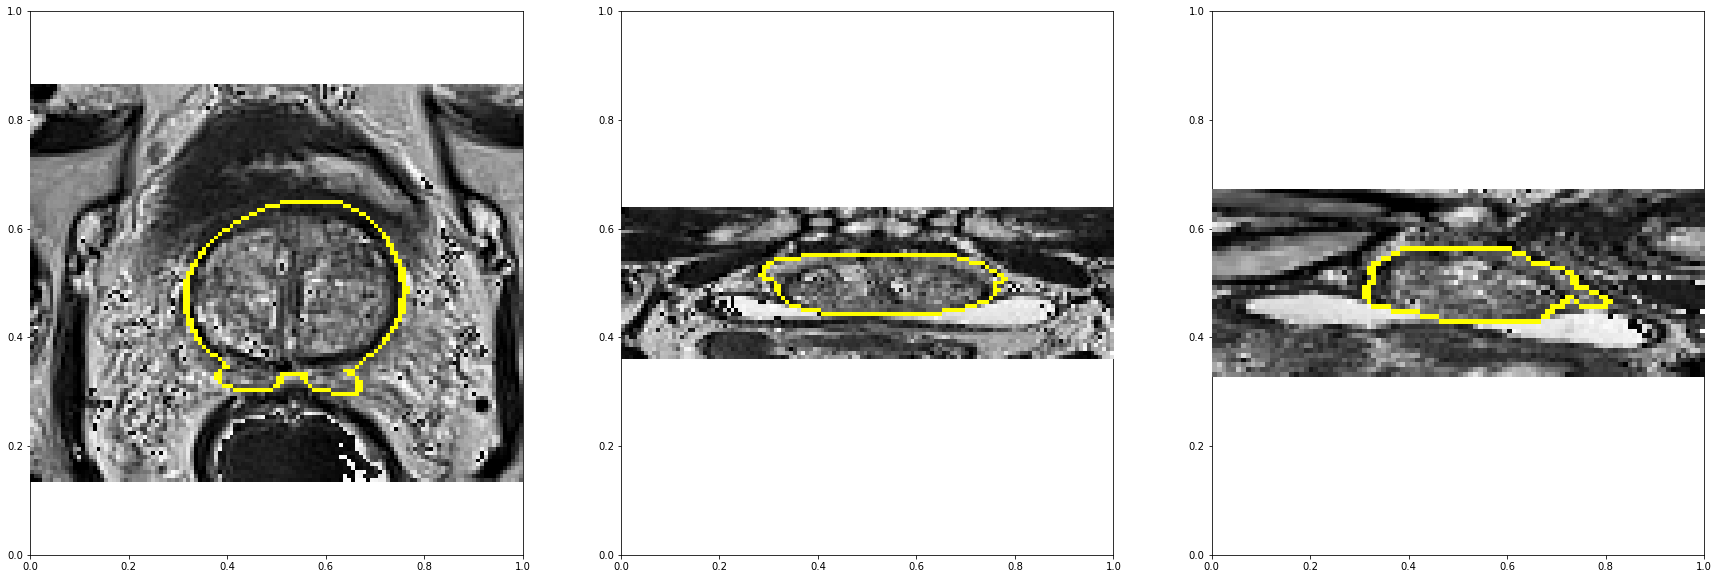

[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]


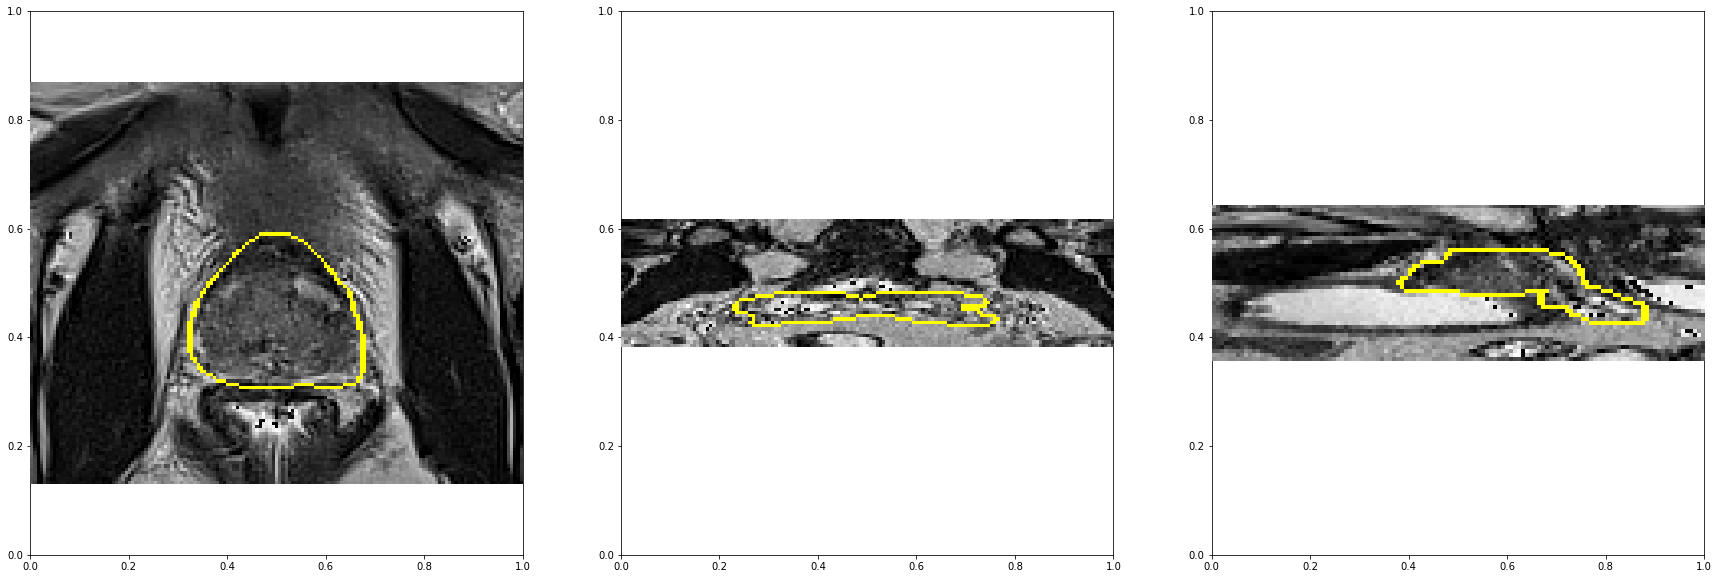

[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]


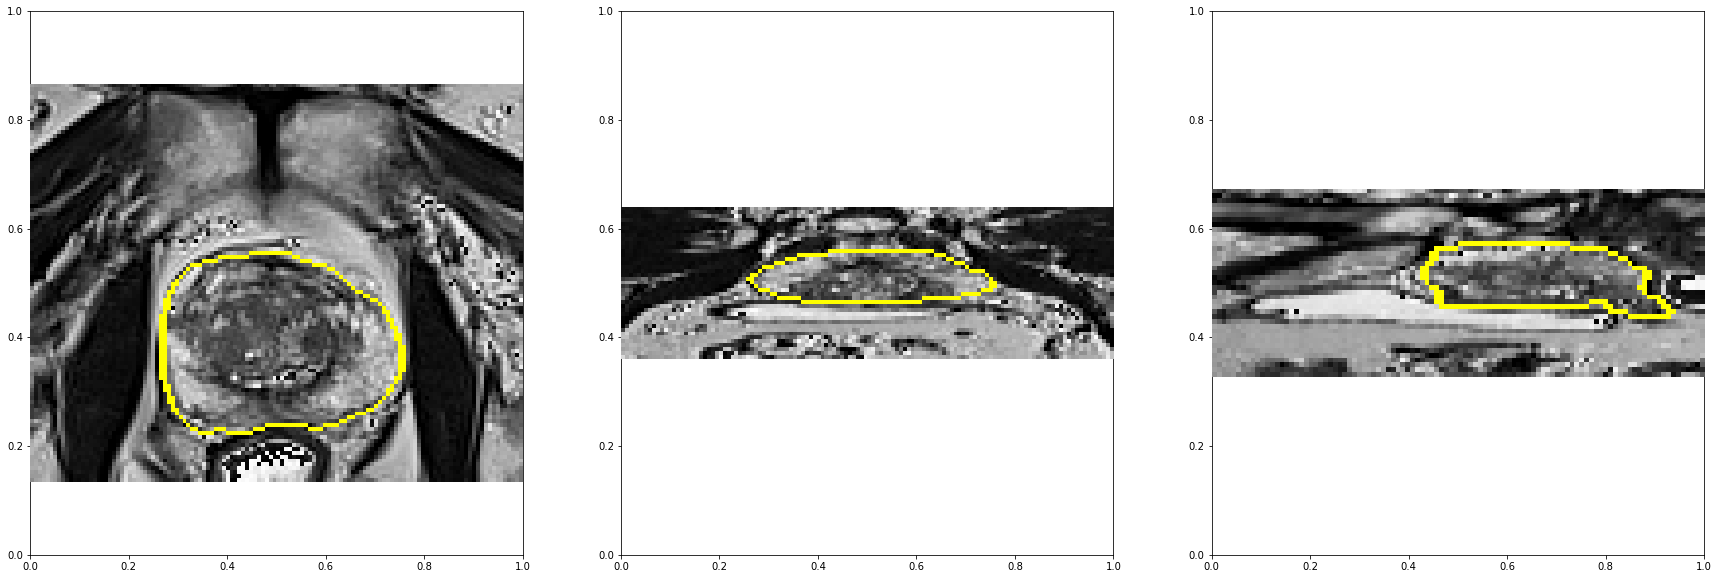

[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]


KeyboardInterrupt: 

In [6]:
"""
segmenation where target is the sum of t2w,adc,hbv labels and we add as input additionally whole prostate segmentations

"""

import SimpleITK as sitk
import mdai
import pandas as pd
import numpy as np
import cv2
import pydicom
import os
import multiprocessing as mp
import functools
from functools import partial
import mdai
import math
import time
import itertools
from pydicom.fileset import FileSet
from os import path as pathOs
from pathlib import Path
import toolz
from toolz.curried import pipe, map, filter, get
from toolz import curry
from os.path import basename, dirname, exists, isdir, join, split
import nnunetv2


from toolz.itertoolz import groupby
from toolz import curry
# import multiprocess
# p = multiprocess.Pool(os.cpu_count())
import multiprocessing as mp
import json
import os
from subprocess import Popen
import subprocess


#metadata directory
resCSVDir='/home/sliceruser/workspaces/konwersjaJsonData/outCsv/resCSV.csv'
#directory with inferred prostates

# dir_inferred_prost='/home/sliceruser/workspaces/konwersjaJsonData/my_prost_infered'

# dir_inferred_prost='/workspaces/prost_anatomy_seg/data/my_prost_infered'
sourceFrame = pd.read_csv(resCSVDir) 
# new_col_name= 'inferred_pg'



def get_id_from_file_name(path_str):
    path_str=path_str.replace('.nii.gz','')
    path_str=path_str[1:5]
    return int(path_str)

# def add_t2w_to_name(source):
#     if(source==' '):
#         return ' '
#     # if('t2w' in source):
#     #     return source
#     # new_path= source.replace('.nii.gz','_t2w.nii.gz')
#     # copy_changing_type(source, new_path)
#     # return new_path
#     return source
    

# def add_inferred_full_prost_to_dataframe(dir_inferred_prost, df,new_col_name):
#     """ 
#     we have some inferred anatomical segmentations done by previous 
#     models now we want to take the folder with 
#     """
#     list_files= os.listdir(dir_inferred_prost)
#     list_files= list(filter(lambda el : el[0]=='9' ,list_files ))
#     list_ids= list(map(get_id_from_file_name,list_files))
#     list_files= list(map( lambda el: f"{dir_inferred_prost}/{el}" ,list_files))
#     file_and_id= dict(list(zip(list_ids,list_files)))
#     new_col_dat= list(map( lambda el: file_and_id.get(el,' ') ,df['masterolds'].to_numpy() ))
#     #changing path name to mark it is t2w related
#     new_col_dat= list(map(add_t2w_to_name,new_col_dat))

#     df[new_col_name]=new_col_dat

#     return df


cols=sourceFrame.columns
noSegCols=list(filter(lambda el: '_noSeg' in el , cols))+['series_MRI_path']
lesion_cols=list(filter(lambda el: 'lesion' in el , noSegCols))
main_modality = 't2w'

# sourceFrame=add_inferred_full_prost_to_dataframe(dir_inferred_prost, sourceFrame,new_col_name)
# modalities that we want to include in the model
main_modality = 't2w'
modalities_of_intrest=['t2w','adc','hbv']

# prostate_col= 'pg_noSeg'
# new_col_name=prostate_col

# new_col_name= 'inferred_pg'

non_mri_inputs=[]
# prostate_col= new_col_name # name of the column with segmentaton of whole prostate gland

anatomic_cols=['afs_noSeg','cz_noSeg','pz_noSeg','tz_noSeg','sv_l_noSeg','sv_r_noSeg','ur_noSeg','pg_noSeg']
# anatomic_cols=['afs_noSeg']

label_cols=anatomic_cols
# label_cols=anatomic_cols+[prostate_col]
channel_names={  
    "0": "t2w", 
    "1": "adc", 
    "2": "hbv", 
    }


label_names= {  
    "background": 0,
    "pz": 1,
    "tz": 2,
    "sv" :3,
    "full_prost":[1,2]
    }

# sv_l_noSeg 'ur' 
# label_names= {  # THIS IS DIFFERENT NOW!
#     "background": 0,
#     "afs": 1,
#     }

def get_int_arr_from_path(pathh):
    """
    given path reads it and return associated array
    then it casts it to boolean data type
    """
    index=15
    to_ignore=False
    if('afs' in pathh):
        index=2
    elif('cz' in pathh):
        index=1        
    elif('pz' in pathh):
        index=1
    elif('tz' in pathh):
        index=2
    elif('sv_l' in pathh):
        index=3    
    elif('sv_r' in pathh):
        index=3          
    # elif('pg_t2w' in pathh):
    #     print(f"pg path {pathh}")

    #     index=9                 
    elif('ur' in pathh):
        index=8          
    else:
        to_ignore=True
    imageA=sitk.ReadImage(pathh)
    imageA=sitk.GetArrayFromImage(imageA)
    if(to_ignore):
        return np.zeros_like(imageA)
    return np.array(imageA.astype(bool).astype(np.uint8) *(index))

def get_int_arr_from_path_full_prostate(pathh):

    index=15
    to_ignore=False      
    if('pg_t2w' in pathh):
        index=9                 
    # elif('ur' in pathh):
    #     index=8          
    else:
        to_ignore=True
    imageA=sitk.ReadImage(pathh)
    imageA=sitk.GetArrayFromImage(imageA)
    if(to_ignore):
        return np.zeros_like(imageA)
    return np.array(imageA.astype(bool).astype(np.uint8) *(index))


def process_labels_prim(labels,group,main_modality,label_new_path,zipped_modalit_path,out_pathsDict):
    # we get the sum of all labels 
    arrays= list(map(get_int_arr_from_path,labels))
    # arrays= list(map(list,arrays))
    reduced = np.sum(np.stack(arrays,axis=0),axis=0).astype(np.uint8)
    arrays_b= list(map(get_int_arr_from_path_full_prostate,labels))
    reduced_b= np.sum(np.stack(arrays_b,axis=0),axis=0).astype(np.uint8)
    #in spots where urethra is set in prostate we set it as tz
    mask=np.logical_and((reduced_b==9),(reduced==8))
    reduced[mask]=2
    #we romeve rest of urethra
    mask= (reduced==8)
    reduced[mask]=0

    print(np.unique(reduced))
    save_from_arr(reduced,sitk.ReadImage(group[1][main_modality][0]),label_new_path)
    return [label_new_path],zipped_modalit_path


def for_filter_unwanted(group):
    """ 
    we want only cases where  afs cz pz and tz are indicated
    """

    # print(f"tttt {group[1]['t2w'][1]}")
    # print(f"lll {len(group[1]['t2w'][1])}")

    # return len(group[1]['t2w'][1])==5
    return True


grouped_rows= main_prepare_nnunet('294',modalities_of_intrest,channel_names,label_names,label_cols,process_labels_prim,non_mri_inputs,sourceFrame,main_modality,for_filter_unwanted)
